### En la presente notebook se hace un análisis exploratorio del dataset obtenido. Para esto se utilizarán varias técnicas utilizando principalmente la librería `Gensim`, la cual provee de una muy buena API para este tipo de trabajos.

In [1]:
import pandas as pd
import re

from nltk.corpus import stopwords

import re
import nltk
import pandas as pd
import numpy as np

import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize

from sklearn.manifold import TSNE
from nltk.cluster import KMeansClusterer

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

Cargamos el dataset obtenido anteriormente

In [2]:
dataset = pd.read_csv('tweets_worldwide_hamburguesa.csv', index_col=False)

Borramos del dataset todos los tuits que no pertenezcan al lenguaje Español

In [3]:
dataset = dataset[dataset['langs']=='es'].drop(columns=['Unnamed: 0']).reset_index(drop=True)

Así luce nuestro dataset crudo. El mismo está compuesto por:

- `screen_names`: nombre del usuario que hizo el tuit
- `texts`: el tuit en cuestión truncado a los primeros 140 caracteres
- `dates`: fecha y hora en la que fue tuiteado
- `langs`: lenguaje del tuit a criterio de la plataforma

In [4]:
dataset

,screen_names,texts,dates,langs
0,excessvs,+ La vida de una italiana estaba llena de clic...,2021-04-28 00:20:33,es
1,EuSiso,tengo +3 meses sin comer hamburguesa o pasta y...,2021-04-28 00:20:28,es
2,_Sosaluis_,Que ganas de una hamburguesa,2021-04-28 00:20:14,es
3,SierraTeff,Milanesa o hamburguesa\nTEAM CAFINAPP,2021-04-28 00:20:06,es
4,DraArias,Estoy haciendo un pan brioche de hamburguesa q...,2021-04-28 00:19:48,es
...,...,...,...,...
9463,isaprzg,tengo unas ganas asquerosas de una hamburguesa...,2021-04-25 21:58:50,es
9464,linternasazules,@Liliththebrat Seis tarrinas de helado de limó...,2021-04-25 21:58:44,es
9465,curly_Bae_bae,me copio grr\nusa 🤢 para marcar lo que no come...,2021-04-25 21:58:44,es
9466,wafibreadbar,usa 🤢 para marcar lo que no comes\n\nmostaza: ...,2021-04-25 21:58:40,es


La función `description_to_words` que se describe a continuación, será la encargada de realizar el preprocesamiento de nuestros tuits aplicándole los siguientes pasos:

1. Se remueven URLS
2. Se remueven las menciones (comienzan con el caracter `@` seguido del nombre de usuario)
3. Se elimina todo caracter que no sea una letra para evitar ruido
4. Se eliminan stopwords del idioma español que no suman significado semántido a la oración

In [5]:
def description_to_words(raw_description):
    no_urls = re.sub("(https?:\/\/)?([\da-z\.-]+)\.([a-z\.]{2,6})([\/\w \.-]*)", "", raw_description)
    no_mentions = re.sub("@[A-Za-z0-9]+","", no_urls)
    letters_only = re.sub("[^a-zA-Zñéáíóúü]", " ", no_mentions)
    letters_only = clean_accents(letters_only)
    words = letters_only.lower().split()
    stops = set(stopwords.words('spanish'))
    meaningful_words = [word for word in words if not word in stops]
    return " ".join(meaningful_words)

def clean_accents(sentence):
    return sentence.replace('á', 'a').replace('é', 'e').replace('í', 'i').replace('ó','o').replace('ú', 'u')

In [6]:
dataset['texts'] = dataset['texts'].apply(description_to_words)

Ejemplo de cómo luce el texto limpio y tokenizado separado por espacios

In [25]:
dataset.iloc[1].texts

'meses comer hamburguesa pasta cuerpo bueno chica entonces'

## A continuación se creará un modelo `Doc2Vec` utilizando la librería `gensim` utilizando el corpus recolectado.

Doc2Vec es un modelo donde, a partir de un corpus dado, se entrenan redes neuronales con el fin de que hallen representaciones vectoriales en espacios de dimensión alta (200 en nuestro caso) conservando información semántica de modo que palabras con significado similar estarán cerca en el espacio.

In [26]:
def generate_tagged_documents(data):
    result = []
    index = 0
    for tweet in data['texts']:
        doc = TaggedDocument(words=tweet.split(), tags=[str(index)])
        result.append(doc)
        index += 1
    return result

In [27]:
def train_doc2vec_model(tagged_data, max_epochs=100, vec_size=200, alpha=0.025, dm=1, hs=1, negative=0):
    model = Doc2Vec(vector_size=vec_size,
                alpha=alpha, 
                min_alpha=0.00025,
                min_count=1,
                dm=dm)
    model.build_vocab(tagged_data)

    for epoch in range(max_epochs):
        print('iteration {0}'.format(epoch))
        model.train(tagged_data,
                    total_examples=model.corpus_count,
                    epochs=100)
        # decrease the learning rate
        model.alpha -= 0.0002
        # fix the learning rate, no decay
        model.min_alpha = model.alpha
    return model

In [28]:
if True:
    model = gensim.models.Doc2Vec.load("doc2vec_splitted.model")

if False:
    tagged_documents = generate_tagged_documents(dataset)
    max_epochs = 100
    vec_size = 100
    alpha = 0.025
    dm = 0
    hs = 0 
    negative = 10

    model = train_doc2vec_model(tagged_documents, max_epochs, vec_size, alpha, dm, hs, negative)

    model.save("doc2vec_splitted.model")

### Visualización de nuestro modelo

En la presente sección, se utilizarán técnicas estadísticas como PCA y T-SNE para proyectar tanto las representaciones de los tweets como las palabras que los componen y así tener una idea visial del espacio latente.

### Visualización de la proyección de tuits
#### Utilizando T-SNE

In [29]:
doc_tags = list(model.docvecs.doctags.keys())
X = model[doc_tags]

tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)

In [30]:
tsne_df = pd.DataFrame(X_tsne, index=doc_tags, columns=['x', 'y'])
print(tsne_df)

              x          y
0    -27.805624   2.253706
1    -43.504028   6.233673
2    -50.353134  -9.729231
3    -15.454523  26.994133
4     -2.872618 -16.105257
...         ...        ...
9463 -59.040001   0.319916
9464 -22.661987 -30.298969
9465   6.467680  38.093105
9466  58.551716  13.327230
9467   4.035076  38.535671

[9468 rows x 2 columns]


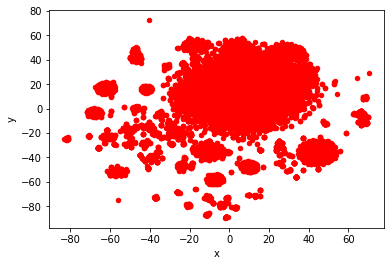

In [16]:
tsne_df.plot(kind='scatter',x='x',y='y',color='red')
plt.show()

Visualizando la representación en dos dimensiones de nuestro espacio, podemos observar que se forman varios clusters de distintos tamaños.

#### Utilizando PCA

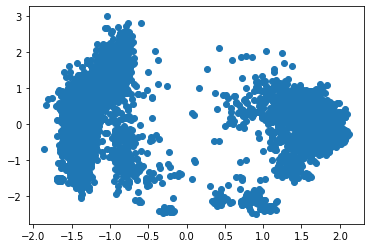

In [39]:
doc_tags = list(model.docvecs.doctags.keys())
X = model[doc_tags]
tweet_pca = PCA(n_components=2)
tweet_pca_result = tweet_pca.fit_transform(X)

plt.scatter(tweet_pca_result[:, 0], tweet_pca_result[:, 1])

Por otro lado, utilizando la técnica basada valores propios (PCA) se pueden observar 2 principales clusters bien identificados

### Visualización del diccionario
#### Utilizando PCA

In [80]:
X = model[model.wv.vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X)

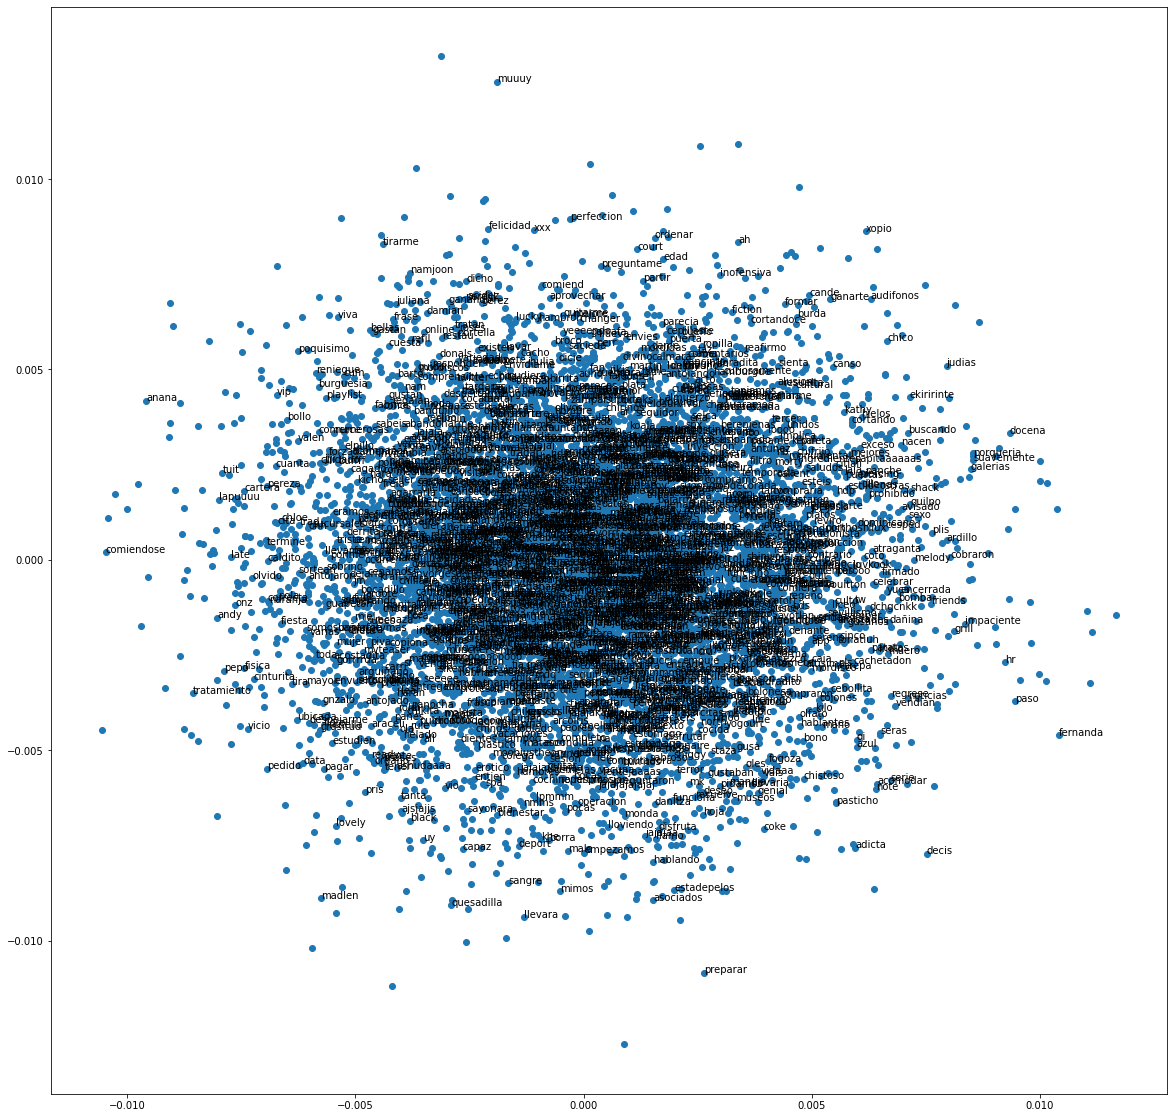

In [81]:
# create a scatter plot of the projection
plt.rcParams["figure.figsize"] = (20,20)

plt.scatter(result[:, 0], result[:, 1])
words = list(model.wv.vocab)
for i, word in enumerate(words):
    if i % 5 == 0:
        plt.annotate(word, xy=(result[i, 0], result[i, 1]))

#### Utilizando T-NSE

In [31]:
doc_tags = list(model.docvecs.doctags.keys())
X = model[model.wv.vocab]

tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)

In [32]:
words_tsne_df = pd.DataFrame(X_tsne, index=None, columns=['x', 'y'])
print(words_tsne_df)

              x          y
0     29.935966 -17.203560
1    -13.382874  15.068700
2    -10.872893  -9.765398
3    -15.341955  -6.854110
4     50.963699  -4.236839
...         ...        ...
8574  46.120617  12.250119
8575 -40.243401   4.302908
8576 -42.841732  26.726505
8577 -29.457289   0.161195
8578  -1.650255 -29.102100

[8579 rows x 2 columns]


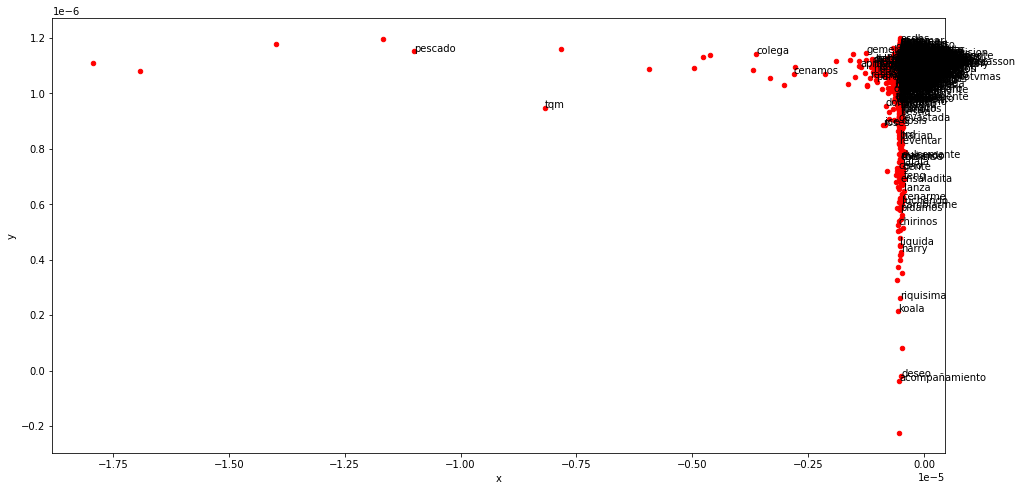

In [92]:
words_tsne_df.plot(kind='scatter',x='x',y='y',color='red', figsize=(16,8))

words = list(model.wv.vocab)
for i, word in enumerate(words):
    if i % 5 == 0:
        plt.annotate(word, xy=(words_tsne_df.iloc[i][0], words_tsne_df.iloc[i][1]))

plt.show()

Ambas proyecciones del diccionario, tanto PCA como T-SNE dejan en evidencia que la distribución del diccionario en el espacio latente es algo caótica, no pudiéndose identificar asociación alguna entre las palabras cercanas.

### Para seguir con el anterior análisis, veremos ejemplos de palabras cercanas según el modelo generado

In [19]:
most_similar_words = model.wv.most_similar_cosmul(positive=['hamburguesa'])

for most_similar_key, similarity in most_similar_words:
    print(f"{most_similar_key}: {similarity:.4f}")

restaurante: 0.6843
gomes: 0.6708
diosss: 0.6671
empezarmelo: 0.6561
computacion: 0.6539
opo: 0.6527
gustas: 0.6520
campeonato: 0.6519
palta: 0.6501
diego: 0.6491


Si observamos las palabras más cercanas de `"hamburguesa"`, vemos que la más cercana es "`restaurante`". Además, dentro de las 10 más cercanas se encuentran `"gustas"` y `"palta"`, pudiéndose estas relacionar también con la comida.

De todas formas, se advierte mucho ruido, lo que podría hablar de la mala calidad de nuestro dataset y lo difícil que es para este tipo de modelos generar una buena representación con el "lenguaje informal" que es utilizado en la plataforma Twitter.

### Estudio de clusters
En la presente sección, se analizan los clusters de tuits para estudiar luego si qué los unifica y obtener más información latente en el espacio. Para esto se utilizará la técnica de kmeans inicializándose con centroides aleatorios hasta que el algoritmo converja.

Se probaron varios números de clusters y se cree que el que mayor sentido tuvo frente a la distribución de los datos fue `N=2`.

In [36]:
doc_tags = list(model.docvecs.doctags.keys())
X = model[doc_tags]

NUM_CLUSTERS=2

kclusterer = KMeansClusterer(NUM_CLUSTERS, distance=nltk.cluster.util.cosine_distance)
assigned_clusters = kclusterer.cluster(X, assign_clusters=True)

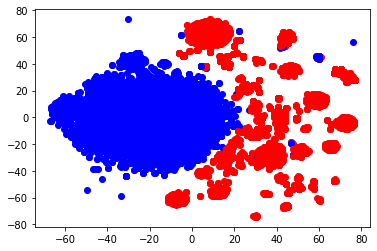

In [37]:
colors = ['blue', 'red']

for index, cluster in zip(range(len(tsne_df)) ,assigned_clusters):
    x = tsne_df.iloc[index]['x']
    y = tsne_df.iloc[index]['y']
    cluster = assigned_clusters[index]
    plt.scatter(x, y, color=colors[int(cluster)])

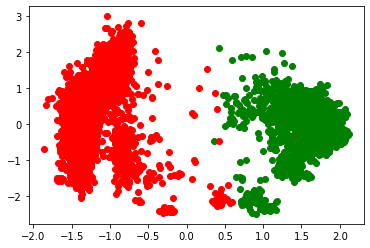

In [40]:
colors = ['red', 'green']

for index, cluster in zip(range(len(tweet_pca_result)), assigned_clusters):
    x = tweet_pca_result[index][0]
    y = tweet_pca_result[index][1]
    cluster = assigned_clusters[index]
    plt.scatter(x, y, color=colors[int(cluster)])

### Estudio de clusters principales

In [45]:
dataset['cluster'] = assigned_clusters

In [47]:
cluster_0_df = dataset[dataset['cluster'] == 0]
cluster_1_df = dataset[dataset['cluster'] == 1]

In [50]:
cluster_0_df

,screen_names,texts,dates,langs,cluster
0,excessvs,vida italiana llena cliches mismo mano rozo kh...,2021-04-28 00:20:33,es,0
1,EuSiso,meses comer hamburguesa pasta cuerpo bueno chi...,2021-04-28 00:20:28,es,0
2,_Sosaluis_,ganas hamburguesa,2021-04-28 00:20:14,es,0
3,SierraTeff,milanesa hamburguesa team cafinapp,2021-04-28 00:20:06,es,0
4,DraArias,haciendo pan brioche hamburguesa saboreando,2021-04-28 00:19:48,es,0
...,...,...,...,...,...
9452,Tweeteameeste,quiero hamburguesa dios mio,2021-04-25 21:59:58,es,0
9462,Che_Bombacha,comer lechuga dentro hamburguesa igual cuenta,2021-04-25 21:58:56,es,0
9463,isaprzg,unas ganas asquerosas hamburguesa papas gajo n...,2021-04-25 21:58:50,es,0
9464,linternasazules,seis tarrinas helado limon galletas chocolate ...,2021-04-25 21:58:44,es,0


### Estudio hora de tuit
En esta última sección del análisis exploratorio del dataset se estudiará la hora en que fue publicado cada tuit para ver si puede sacarse alguna información del dato que luego fuera útil para la construcción de nuestro negocio ficticio.

In [78]:
dataset['dates'] = pd.to_datetime(dataset.dates)

In [79]:
dataset['dates'] = dataset['dates'].dt.hour
dataset

,screen_names,texts,dates,langs,cluster
0,excessvs,vida italiana llena cliches mismo mano rozo kh...,0,es,0
1,EuSiso,meses comer hamburguesa pasta cuerpo bueno chi...,0,es,0
2,_Sosaluis_,ganas hamburguesa,0,es,0
3,SierraTeff,milanesa hamburguesa team cafinapp,0,es,0
4,DraArias,haciendo pan brioche hamburguesa saboreando,0,es,0
...,...,...,...,...,...
9463,isaprzg,unas ganas asquerosas hamburguesa papas gajo n...,21,es,0
9464,linternasazules,seis tarrinas helado limon galletas chocolate ...,21,es,0
9465,curly_Bae_bae,copio grr usa marcar comes mayonesa dulce lech...,21,es,1
9466,wafibreadbar,usa marcar comes mostaza pepinillo cilantro pi...,21,es,1


<AxesSubplot:xlabel='dates'>

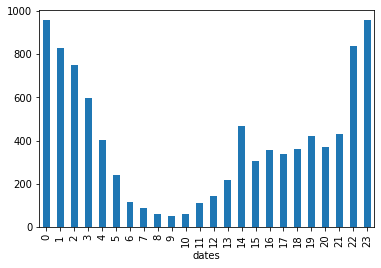

In [81]:
dataset['dates'].groupby([dataset['dates']]).count().plot(kind='bar')

De esta gráfica podemos observar que la gente tiende a utilizar el término "hamburguesa" entre las 22hs y las 02hs con otro pico en las 14hs. Podemos pensar que estas horas coinciden con la hora que la gente cena o almuerza y en esas horas deberíamos ofrecer nuestros productos o invertir en publicidad en esas horas al menos en la red social Twitter.